# Capstone Project - Tastes of London

In [137]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift
import folium
import requests
from IPython.display import Image 
from IPython.core.display import HTML
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

Solving environment: ...working... done

# All requested packages already installed.



In [ ]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim

## 1. Extract data and clean them up

Data needed for the project includes list of London areas in London with coordinates. We have donwloaded this data from external data and saved it down in csv file. This csv file will be used for the exercise - some clearning up is needed to get the data to the desired format.

We picked district postcodes as a unit for analysis. We tried to determine which unit will be most useful for the type of analysis that we would like to do. Other options considered and rejected included:

Boroughs - There are 32 boroughs in London. London is a diverse city with many different areas and dividing it into only 32 areas would mean that each area is very large and potentially includes a lot of small meighbourhoods that are very different. Using boroughs could thus inhibit ability to perform meaningful analysis as variations between neighbourhoods would be lost in larage boroughs. Thus, this option was rejected.

Postcodes - We considered use of postcodes to perform analysis. However, there are thousands of postcodes in London, thus it would likely to result in many clusters or many items in each clusters, which would be difficult to analyse and use in practice. Thus, this option was rejected.

This led us to the chosen option - district postcodes. There are 119 postcode districts, which was considered to provide healthy balance between having enough granularity to capture neighborhood characteristics but still being a number that in manageable to analyse.

In [2]:
# download data from the file
raw_data = pd.read_csv('Postcode districts.csv')

In [3]:
# see number of columns in our data
raw_data.shape

(440, 4)

In [4]:
# see titles of columns in our data
raw_data.columns

Index(['Postcode', 'Area Name', 'Latitude', 'Longitude'], dtype='object')

In [5]:
# see dataframe
raw_data.head()

,Postcode,Area Name,Latitude,Longitude
0,E1,Aldgate,51.5163,-0.060423
1,E1,Bethnal Green,51.5163,-0.060423
2,E1,City of London,51.5163,-0.060423
3,E1,Mile End,51.5163,-0.060423
4,E1,Shoreditch,51.5163,-0.060423


In [6]:
# Combine rows where postcode is the same and display Area Names after commas
london_data = raw_data.groupby(['Postcode'])['Area Name'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

In [7]:
# merge list with combined rows where postdoe is the same with latitudes and longitudes
london_data = london_data.merge(raw_data.drop_duplicates(["Postcode"]), how = 'left', left_on = 'Postcode', right_on='Postcode')

In [8]:
# see shape of our data after rows reduced to unique postcodes
london_data.shape

(119, 5)

In [9]:
# reformat and see dataframe
london_data = london_data.drop('Area Name_y', axis = 1)
london_data = london_data.rename(columns={"Area Name_x": "Area Name"})

,Postcode,Area Name,Latitude,Longitude
0,E1,"Aldgate, Bethnal Green, City of London, Mile E...",51.5163,-0.060423
1,E10,Leyton,51.5687,-0.012773
2,E11,"Leyton, Leytonstone, Wanstead",51.5674,0.011669
3,E12,"East Ham, Manor Park, Wanstead",51.5510,0.050806
4,E13,"Plaistow, West Ham",51.5282,0.025794


### Conclusion

Data is now cleaned and has all needed attributes - list of postcodes together with latitude and longitude information for each postcode.

## 2. Define Foursquare credentials and get venues data for all postcodes

We used Foursquare API to get information on venues in each area. As the topic of analysis is cuisines, only restaurants are venues that bring insight into this analysis, thus we only used venues from 'Food' category.

In [10]:
# define Foursquare credentials

# Natusia
# CLIENT_ID = 'HQUVEV3U1ZWEENJRKMNEIL0ECUXT0QWGKZZCH1V3PHG1ZTDR'
# CLIENT_SECRET = 'TGZJTR4DQ33KOMCUI4IM3UK54WB5Z0POXHFUWIFEQGTTUB2I'

# Marianek
CLIENT_ID = 'LXI1GUWHWH14DR02SBUCLEHQYQHJ5HCOAQ0GVPSTVKTHUJ4O'
CLIENT_SECRET = 'N0ALKOBBYH3OS1Q21M4SPBCHICVMHMSRE0AUJRU1K5LJAUTE'
VERSION = '20200503'
LIMIT = 100

In [12]:
# create function to extract 'Food' venues data for each postcode from Foursquare API

def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format( 
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            '4d4b7105d754a06374d81259', # extract only venues that fall under 'Food' category
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',]
    
    return(nearby_venues)

In [19]:
# create new dataframe with postcode and venues data
london_venues = getNearbyVenues(names=london_data['Postcode'],
                                   latitudes=london_data['Latitude'],
                                   longitudes=london_data['Longitude']
                                  )

E1
E10
E11
E12
E13
E14
E15
E16
E17
E18
E2
E3
E4
E5
E6
E7
E8
E9
EC1
EC2
EC3
EC4
N1
N10
N11
N12
N13
N14
N15
N16
N17
N18
N19
N2
N20
N21
N22
N3
N4
N5
N6
N7
N8
N9
NW1
NW10
NW11
NW2
NW3
NW4
NW5
NW6
NW7
NW8
NW9
SE1
SE10
SE11
SE12
SE13
SE14
SE15
SE16
SE17
SE18
SE19
SE2
SE20
SE21
SE22
SE23
SE24
SE25
SE26
SE27
SE28
SE3
SE4
SE5
SE6
SE7
SE8
SE9
SW1
SW10
SW11
SW12
SW13
SW14
SW15
SW16
SW17
SW18
SW19
SW2
SW20
SW3
SW4
SW5
SW6
SW7
SW8
SW9
W1
W10
W11
W12
W13
W14
W2
W3
W4
W5
W6
W7
W8
W9
WC1
WC2


In [20]:
# count how many venues were returned for each postcode
groups = london_venues.groupby('Neighborhood').count()
groups

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
E1,100,100,100,100,100,100
E10,23,23,23,23,23,23
E11,26,26,26,26,26,26
E12,8,8,8,8,8,8
E13,12,12,12,12,12,12
...,...,...,...,...,...,...
W7,16,16,16,16,16,16
W8,100,100,100,100,100,100
W9,87,87,87,87,87,87


In [21]:
# see how many postcodes have maximum amount of restaurants (100)
groups[groups['Venue'] == 100].count()

Neighborhood Latitude     24
Neighborhood Longitude    24
Venue                     24
Venue Latitude            24
Venue Longitude           24
Venue Category            24
dtype: int64

In [22]:
# see how many postcodes have >10 restuarants
groups[groups['Venue'] > 10].count()

Neighborhood Latitude     109
Neighborhood Longitude    109
Venue                     109
Venue Latitude            109
Venue Longitude           109
Venue Category            109
dtype: int64

In [23]:
# see how many unique categories there are
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 133 uniques categories.


In [24]:
# print out the list of categories
london_venues['Venue Category'].unique()

array(['Kebab Restaurant', 'Indian Restaurant', 'North Indian Restaurant',
       'Bakery', 'Middle Eastern Restaurant', 'Italian Restaurant',
       'Restaurant', 'French Restaurant', 'Korean Restaurant', 'Creperie',
       'Pizza Place', 'Café', 'Vegetarian / Vegan Restaurant',
       'Japanese Restaurant', 'BBQ Joint', 'Falafel Restaurant',
       'Sandwich Place', 'Deli / Bodega', 'Sushi Restaurant',
       'Burger Joint', 'Chinese Restaurant', 'Salad Place',
       'Thai Restaurant', 'Turkish Restaurant', 'Szechuan Restaurant',
       'Food Court', 'Gastropub', 'Wings Joint', 'Asian Restaurant',
       'Vietnamese Restaurant', 'Malay Restaurant', 'Filipino Restaurant',
       'Greek Restaurant', 'Food Truck', 'Portuguese Restaurant',
       'Steakhouse', 'Fast Food Restaurant', 'English Restaurant',
       'African Restaurant', 'Snack Place', 'Breakfast Spot',
       'Fried Chicken Joint', 'Fish & Chips Shop',
       'Mediterranean Restaurant', 'Dim Sum Restaurant', 'Irish Pub',
 

### Evaluation of venues data received and conclusion

When we were extracting data from Foursquare we were doing pre-analysis of results above to see if parameters were chosen in reasonable way. 

Primary variable that had to be chosen was radius. Initially, we chose radius of 500, but this resulted in some postcodes having very low volume of restaurants, which would inhibit ability for meaningul clustering. Thus, we extended radius to 1,000, which resulted in 109 our of 119 postcodes having more than 10 restaurants and 24 out of 100 having maximum amount of 100 restaurants. This is considered a good balance - almost all restaurants have enough data to allow for analysis and the proportion of postcodes that exceed limit of 100 is not too large (too large proportion of postcodes reaching the limit could also inhibit analysis - it would mean that we are only extracting a fraction of all restaurants, which may bias the true proportion of different restaurants within particular postcode).

Another variable that was chosen was category of venues extracted from Foursquare API - we chose Category ID 'Food'. We checked that our data have 133 unique categories of restaurants and then displayed all restuarants. The purpose was to check whether category appropriately reflects type of venues we intended to use for analysis. Upon review of count of categories and scan of category names (see above), we conclude that they are reasonable and fit for our analysis.

The data is now ready for clustering.

## 3. Analyze each postcode

We used one hot encoding to analyze restaurant data for each postcode. We performed analysis to determine what are 10 most common restaurants in each neighborhood.

In [25]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]
london_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,E1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,E1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,E1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,E1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,E1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
# group rows by neighborhood and by taking mean of frequency of occurance of each category
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()

In [28]:
# print each neighborhood along with top 5 most common venues
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----E1----
               venue  freq
0  Indian Restaurant  0.13
1               Café  0.11
2        Pizza Place  0.07
3     Sandwich Place  0.06
4             Bakery  0.04


----E10----
                 venue  freq
0                 Café  0.17
1   Chinese Restaurant  0.13
2  Fried Chicken Joint  0.09
3    Fish & Chips Shop  0.09
4     Asian Restaurant  0.09


----E11----
                  venue  freq
0                  Café  0.23
1    Italian Restaurant  0.08
2  Fast Food Restaurant  0.08
3           Pizza Place  0.08
4       Thai Restaurant  0.08


----E12----
                   venue  freq
0      Indian Restaurant  0.75
1             Restaurant  0.25
2            Wings Joint  0.00
3  Vietnamese Restaurant  0.00
4      Polish Restaurant  0.00


----E13----
                 venue  freq
0                 Café  0.50
1   African Restaurant  0.08
2  Fried Chicken Joint  0.08
3     Asian Restaurant  0.08
4    Indian Restaurant  0.08


----E14----
                venue  freq
0      Sandwich

                venue  freq
0              Bakery  0.14
1                Café  0.12
2  Italian Restaurant  0.07
3  Turkish Restaurant  0.07
4   Korean Restaurant  0.07


----NW2----
                  venue  freq
0  Fast Food Restaurant  0.33
1                  Café  0.13
2        Breakfast Spot  0.13
3     Afghan Restaurant  0.07
4            Bagel Shop  0.07


----NW3----
                 venue  freq
0                 Café  0.20
1               Bakery  0.12
2   Italian Restaurant  0.11
3          Pizza Place  0.07
4  Japanese Restaurant  0.04


----NW4----
                venue  freq
0    Sushi Restaurant  0.11
1         Pizza Place  0.11
2  Chinese Restaurant  0.11
3                Café  0.11
4   Indian Restaurant  0.05


----NW5----
                venue  freq
0                Café  0.27
1  Italian Restaurant  0.09
2   French Restaurant  0.06
3              Bakery  0.04
4           Gastropub  0.04


----NW6----
                  venue  freq
0                  Café  0.13
1           

                venue  freq
0                Café  0.15
1  Italian Restaurant  0.13
2         Pizza Place  0.08
3              Bakery  0.07
4           Gastropub  0.06


----SW7----
                venue  freq
0                Café  0.15
1  Italian Restaurant  0.11
2              Bakery  0.06
3   French Restaurant  0.05
4      Sandwich Place  0.05


----SW8----
                   venue  freq
0  Portuguese Restaurant  0.18
1      Indian Restaurant  0.08
2   Fast Food Restaurant  0.08
3                   Café  0.08
4             Restaurant  0.08


----SW9----
                   venue  freq
0                   Café  0.09
1   Caribbean Restaurant  0.08
2    Fried Chicken Joint  0.07
3            Pizza Place  0.06
4  Portuguese Restaurant  0.06


----W1----
                venue  freq
0   French Restaurant  0.10
1   Indian Restaurant  0.07
2  Italian Restaurant  0.07
3  Seafood Restaurant  0.07
4          Steakhouse  0.06


----W10----
                     venue  freq
0                     

In [29]:
# put it into dataframe and sort in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
# create new dataframe and display top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,Indian Restaurant,Café,Pizza Place,Sandwich Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Italian Restaurant,Chinese Restaurant,Burger Joint
1,E10,Café,Chinese Restaurant,Asian Restaurant,Fish & Chips Shop,Restaurant,Fried Chicken Joint,Indian Restaurant,Sandwich Place,Mediterranean Restaurant,Vegetarian / Vegan Restaurant
2,E11,Café,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Thai Restaurant,Italian Restaurant,Bakery,Dim Sum Restaurant,Restaurant
3,E12,Indian Restaurant,Restaurant,Donut Shop,Falafel Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant
4,E13,Café,Indian Restaurant,Bakery,Vietnamese Restaurant,African Restaurant,Asian Restaurant,Fried Chicken Joint,Falafel Restaurant,Ethiopian Restaurant,English Restaurant


### Conclusion

We have list of postcodes with top 10 most common restaurants for each postcode. We can move to the next stage - clustering.

## 4. Cluster Postcodes

We used K-means to perform clustering of postcodes.  

In [143]:
london_grouped_clustering

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Bagel Shop,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Veneto Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,0.0,0.010000,0.000000,0.0,0.000000,0.020000,0.0,0.000000,0.020000,0.0,...,0.00,0.020000,0.0,0.020000,0.0,0.040000,0.0,0.010000,0.01,0.0
1,0.0,0.000000,0.000000,0.0,0.000000,0.086957,0.0,0.000000,0.043478,0.0,...,0.00,0.000000,0.0,0.000000,0.0,0.043478,0.0,0.000000,0.00,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00,0.076923,0.0,0.000000,0.0,0.000000,0.0,0.038462,0.00,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0
4,0.0,0.083333,0.000000,0.0,0.000000,0.083333,0.0,0.000000,0.000000,0.0,...,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.083333,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.0,0.000000,0.000000,0.0,0.000000,0.062500,0.0,0.000000,0.000000,0.0,...,0.00,0.062500,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0
115,0.0,0.000000,0.010000,0.0,0.000000,0.020000,0.0,0.000000,0.000000,0.0,...,0.00,0.050000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00,0.0
116,0.0,0.000000,0.011494,0.0,0.000000,0.000000,0.0,0.011494,0.000000,0.0,...,0.00,0.045977,0.0,0.011494,0.0,0.022989,0.0,0.000000,0.00,0.0
117,0.0,0.000000,0.000000,0.0,0.011111,0.011111,0.0,0.000000,0.000000,0.0,...,0.00,0.033333,0.0,0.022222,0.0,0.011111,0.0,0.044444,0.00,0.0


In [122]:
# set number of clusters
kclusters = 6

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 4, 3, 1, 1, 1, 0, 0])

In [123]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(columns=["Cluster Labels"])

In [124]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [125]:
# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Postcode')

london_merged.head()

,Postcode,Area Name,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,E1,"Aldgate, Bethnal Green, City of London, Mile E...",51.5163,-0.060423,1,Indian Restaurant,Café,Pizza Place,Sandwich Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Italian Restaurant,Chinese Restaurant,Burger Joint
1,E10,Leyton,51.5687,-0.012773,0,Café,Chinese Restaurant,Asian Restaurant,Fish & Chips Shop,Restaurant,Fried Chicken Joint,Indian Restaurant,Sandwich Place,Mediterranean Restaurant,Vegetarian / Vegan Restaurant
2,E11,"Leyton, Leytonstone, Wanstead",51.5674,0.011669,0,Café,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Thai Restaurant,Italian Restaurant,Bakery,Dim Sum Restaurant,Restaurant
3,E12,"East Ham, Manor Park, Wanstead",51.5510,0.050806,4,Indian Restaurant,Restaurant,Donut Shop,Falafel Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant
4,E13,"Plaistow, West Ham",51.5282,0.025794,3,Café,Indian Restaurant,Bakery,Vietnamese Restaurant,African Restaurant,Asian Restaurant,Fried Chicken Joint,Falafel Restaurant,Ethiopian Restaurant,English Restaurant


In [126]:
# determine latitude and longitude of London to allow to create map
address = 'London'

geolocator = Nominatim(user_agent="london_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [139]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Postcode'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Conclusion

Clustering has been performed and map provides visual representation of clusters. We will first check what the optimal number of clusters is (this is done in section 5 below - optimal number of clusters is already used in computations performed above). After that, we can move to analysis of clusters to draw conclusions.

## 5. Check optimal number of clusters

Our initial run of clustering was performed with pre-determined number of clusters, which may be not optimal for the dataset. After we have done the clustering, we want to determine what may be optimal number of clusters to use to get most informative result. To do that, we use Elbow Method and Silhouette Method, as per below.

Based on those methods, we determined that 6 clusters will be optimal for our analysis and that is why section 4. above is performed with use of that amount of clusters.

### Elbow Method

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
# run K-means for number of clusters ranging from 1 to 30 and collect in dataframe size of error for each run
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(london_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

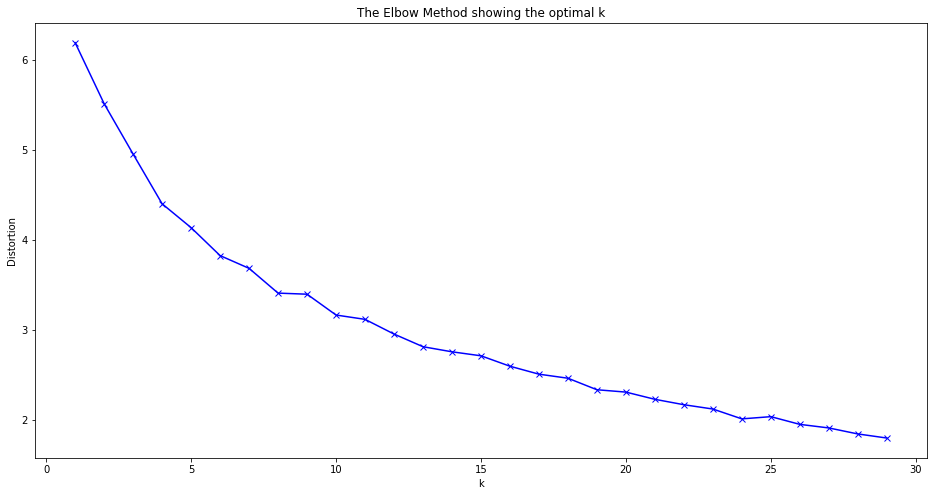

In [52]:
# plot errors for K-means run for particular number of clusters
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Conclusion re optimal number of clusters based on Elbow Method

When using Elbow Method, we are looking for a 'kink' that would show at which number of clusters the error size starts decreasing at much slower rate. However, looking at the graph above we can see that error rate falls at fairly constant rate as number of clusters increases. Hence, it gives us little insight into optimal number of clusters.

We will use Silhouette Method, which is more sophisticated than Elbow Method, and thus may provide more informative result.

### Silhouette Method

In [54]:
from sklearn.metrics import silhouette_score

In [71]:
# run K-means for number of clusters ranging from 2 to 30 and collect in dataframe size of error for each run
distortions_silhouette = []
Ks = range(2,30)
for n_clusters in Ks:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    y = clusterer.fit_predict(london_grouped_clustering)
    score = round(silhouette_score(london_grouped_clustering, y), 2)
    distortions_silhouette.append(score)

#    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4), dpi=500)
#    ax1 = silhouette_plot(X, y, n_clusters=n_clusters, ax=ax1)
#    ax2 = kmeans_plot(X, y, clusterer.cluster_centers_, ax=ax2)


#    fig.subplots_adjust(top=0.825)
#    fig.suptitle(("Silhouette Analysis for KMeans Clustering on Iris Data "
#                  "\n$clusters = {}$".format(n_clusters)),
#                 fontsize=14, fontweight='bold')
#    message = "For n_clusters = {} The average silhouette_score is: {}"
#    print(message.format(n_clusters, round(silhouette_score(london_grouped_clustering, y), 2)))

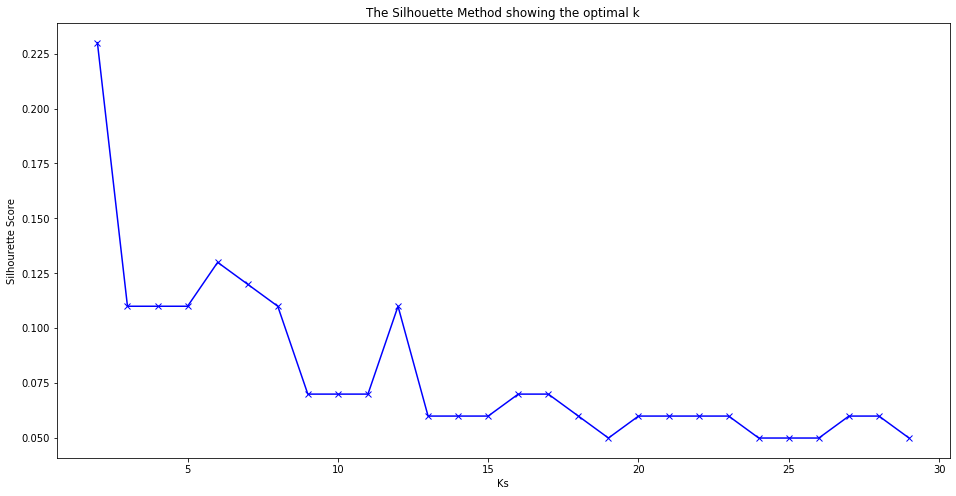

In [136]:
# plot errors for K-means run for particular number of clusters
plt.figure(figsize=(16,8))
plt.plot(Ks, distortions_silhouette, 'bx-')
plt.xlabel('Ks')
plt.ylabel('Silhourette Score')
plt.title('The Silhouette Method showing the optimal k')
plt.show()

### Conclusion re optimal number of clusters based on Elbow Method

When using Silhouette Method, we are looking for a number of clusters for which Silhouette Score is maximised. In the graph above, we can see that Silhouette Score reaches maximium for 2 clusters. However, due to large size of London and high number of postcodes, 2 clusters are unlikely to show enough variation to capture the types of differences we are interested in. Second highest Silhouette Score is for 6 clusters. Thus, this is the number of clusters that we will use for our clustering.

Based on analysis, 6 clusters are considered to be optimal amount and will be used for analysis.

## Examine Clusters

We have not finalised clustering and are perfoming analysis of clusters in this section to draw conclusions.

In [128]:
# check number of postcodes in each cluster
london_merged['Cluster Labels'].value_counts()

1    57
0    46
3     7
5     5
2     3
4     1
Name: Cluster Labels, dtype: int64

#### Comments: 
We note that clusters 0 and 1 contain majority of the postcodes (87%). Since each of those clusters includes large number of postcodes, it is less likely to be useful, as it does not narrow down the population of all London areas much. Cluster 4 has only one postcode in it, which also means that its usefulness it is limited - it rather captures an outlier than any trend. While we analyse all clusters below, greater emphasis and value is likely to come from clusters 2, 3 and 5.

#### Analysis - Cluster 0 (Red)

Cluster zero has 46 neighborhoods. As it can be seen from the map above, it primarily includes locations in East London. Cafes dominate in all postcodes as most common venue. Pizza places, fast food restaurants and bakeries are also high on the list of most common venues. Location and most common venues indicate that:
 - those are primarily residental areas
 - price range of venues is likely to be relatively low due to their nature
 
 Those could be good locations for business owners looking to set up businesses targeting day-to-day spending done close to home.

In [129]:
london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Leyton,Café,Chinese Restaurant,Asian Restaurant,Fish & Chips Shop,Restaurant,Fried Chicken Joint,Indian Restaurant,Sandwich Place,Mediterranean Restaurant,Vegetarian / Vegan Restaurant
2,"Leyton, Leytonstone, Wanstead",Café,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Sandwich Place,Thai Restaurant,Italian Restaurant,Bakery,Dim Sum Restaurant,Restaurant
8,"Leyton, Walthamstow",Café,Fast Food Restaurant,Pizza Place,Restaurant,Sandwich Place,Bakery,Italian Restaurant,Chinese Restaurant,Indian Restaurant,Middle Eastern Restaurant
9,"South Woodford, Wanstead, Woodford",Italian Restaurant,Café,Indian Restaurant,Fast Food Restaurant,Chinese Restaurant,BBQ Joint,Greek Restaurant,Pizza Place,Seafood Restaurant,Bakery
10,"Bethnal Green, Shoreditch, Stepney",Café,Bakery,Pizza Place,Restaurant,Turkish Restaurant,Italian Restaurant,Tapas Restaurant,Fast Food Restaurant,Breakfast Spot,Japanese Restaurant
11,"Bethnal Green, Bow, Bromley by Bow, Poplar, St...",Café,Pizza Place,Fast Food Restaurant,Burger Joint,Fish & Chips Shop,Fried Chicken Joint,Persian Restaurant,Lebanese Restaurant,Sandwich Place,Snack Place
13,"Clapton, Hackney",Café,Breakfast Spot,Chinese Restaurant,Pizza Place,Turkish Restaurant,Diner,Dumpling Restaurant,Japanese Restaurant,Fast Food Restaurant,French Restaurant
16,"Dalston, Hackney, Shoreditch",Café,Restaurant,Bakery,Pizza Place,Vietnamese Restaurant,Sandwich Place,Middle Eastern Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Breakfast Spot
17,"Hackney, Homerton, Poplar",Café,Bakery,Vietnamese Restaurant,Middle Eastern Restaurant,Pizza Place,Restaurant,Vegetarian / Vegan Restaurant,Fish & Chips Shop,Fast Food Restaurant,Indian Restaurant
23,"Hornsey, Muswell Hill, Wood Green",Café,Pizza Place,Deli / Bodega,Restaurant,Indian Restaurant,Bakery,English Restaurant,Japanese Restaurant,Thai Restaurant,American Restaurant


#### Analysis - Cluster 1 (Purple)

Cluster one has 57 neighborhoods. As it can be seen from the map above, it primarily includes locations in West London. While cafes are still frequent as most common venue, a significant proportion of neighorhoods has a restaurant as their most common venue. The proportion of restaurants versus bakeries/sandwich places/pizza places is greater than in cluster 1. This indicates that:
 - those are primarily in the city center and more wealthy residential areas
 - price range of venues is likely to be relatively high due to their nature
 
 Those could be good locations for business owners looking to set up businesses targeting higher end of the market. Any modern/fusion kitchen establishments are also most likely to find customer base in those areas.

In [130]:
london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Aldgate, Bethnal Green, City of London, Mile E...",Indian Restaurant,Café,Pizza Place,Sandwich Place,Vegetarian / Vegan Restaurant,Fast Food Restaurant,Bakery,Italian Restaurant,Chinese Restaurant,Burger Joint
5,"Isle of Dogs, Millwall, Poplar, Stepney",Sandwich Place,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Café,Burger Joint,Bakery,Pizza Place,Restaurant,English Restaurant
6,"Canning Town, Hackney, Leyton, Poplar, Stratfo...",Café,Indian Restaurant,Pizza Place,Sandwich Place,Thai Restaurant,Bakery,Burger Joint,Italian Restaurant,Restaurant,Tapas Restaurant
7,"Canning Town, Docklands, East Ham, North Woolw...",Café,Sandwich Place,Chinese Restaurant,Fast Food Restaurant,Bakery,Pizza Place,Restaurant,Middle Eastern Restaurant,English Restaurant,Italian Restaurant
12,"Chingford, Highams Park, Stepney",Pizza Place,Fast Food Restaurant,English Restaurant,Sandwich Place,Italian Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant
14,"Barking, Beckton, East Ham",Fast Food Restaurant,Thai Restaurant,Chinese Restaurant,Sandwich Place,Café,Pizza Place,Indian Restaurant,Turkish Restaurant,German Restaurant,Empanada Restaurant
18,"Barbican, City of London, Clerkenwell, Finsbur...",French Restaurant,Italian Restaurant,Sandwich Place,Food Truck,Vietnamese Restaurant,Café,Falafel Restaurant,Burrito Place,Pizza Place,Salad Place
19,"Bishopsgate, City of London, Finsbury, Liverpo...",Italian Restaurant,Food Truck,Sushi Restaurant,French Restaurant,Salad Place,Café,Vietnamese Restaurant,Japanese Restaurant,Modern European Restaurant,English Restaurant
20,"Aldgate, City of London, Fenchurch Street, Mon...",Italian Restaurant,Café,Restaurant,French Restaurant,Seafood Restaurant,Steakhouse,Indian Restaurant,Salad Place,Burger Joint,BBQ Joint
21,"Blackfriars, City of London, Fleet Street, St....",Italian Restaurant,French Restaurant,Restaurant,Café,Sandwich Place,Sushi Restaurant,Modern European Restaurant,Vietnamese Restaurant,Falafel Restaurant,English Restaurant


#### Analysis - Cluster 2 (Blue)

Cluster two has 3 neighborhoods. They are all in relative proximity to each other, north of the city centre. As it can be seen below, turkish restaurants are most common venue in all 3 neighborhoods. While it is likely that the Turkish restaurant market may be saturated in those locations, any businesses that think their products would appeal to same customer base that like turkish restaurants, should consider those nighborhoods as potentially attractive locations.

In [131]:
london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,"Seven Sisters, South Tottenham",Turkish Restaurant,Café,Pizza Place,Fried Chicken Joint,Fast Food Restaurant,Bakery,Chinese Restaurant,Sandwich Place,Breakfast Spot,Cigkofte Place
31,Upper Edmonton,Turkish Restaurant,Pizza Place,Café,Fast Food Restaurant,Kebab Restaurant,Sandwich Place,Asian Restaurant,Chinese Restaurant,Bakery,Bistro
43,Lower Edmonton,Turkish Restaurant,Café,Indian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Fast Food Restaurant,Breakfast Spot,Seafood Restaurant,Kebab Restaurant,Bakery


#### Analysis - Cluster 3 (Turquoise)

Cluster three has 7 neighborhoods. While located in different parts if the city, they are all clearly in the outskirts. As it can be seen in the list below, those locations have large variety of exotic cuisines from differents parts of the world. Those locations can be interesting for business owners looking to set up restaurants that serve ethinic cuisine, as clearly demand for such products is present in those areas. 

In [132]:
london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,"Plaistow, West Ham",Café,Indian Restaurant,Bakery,Vietnamese Restaurant,African Restaurant,Asian Restaurant,Fried Chicken Joint,Falafel Restaurant,Ethiopian Restaurant,English Restaurant
15,"East Ham, Forest Gate, Upton Park, Wanstead, W...",Café,Indian Restaurant,Bakery,Fish & Chips Shop,Fast Food Restaurant,Restaurant,Chinese Restaurant,Comfort Food Restaurant,Asian Restaurant,Deli / Bodega
24,"Friern Barnet, New Southgate",Indian Restaurant,Café,Chinese Restaurant,Fast Food Restaurant,Fish & Chips Shop,Diner,Dim Sum Restaurant,Doner Restaurant,Deli / Bodega,Dumpling Restaurant
66,"Abbey Wood, Erith, Woolwich",Fish & Chips Shop,Bakery,Café,Indian Restaurant,Himalayan Restaurant,Halal Restaurant,Czech Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
72,"Croydon, Lambeth, South Norwood",Café,Fish & Chips Shop,Asian Restaurant,Caribbean Restaurant,Indian Restaurant,Halal Restaurant,Falafel Restaurant,Deli / Bodega,Dim Sum Restaurant,Diner
95,"Cottenham Park, Merton, Raynes Park, West Wimb...",Indian Restaurant,Café,Fast Food Restaurant,Chinese Restaurant,BBQ Joint,Burger Joint,Fried Chicken Joint,Korean Restaurant,Japanese Restaurant,Bakery
114,Hanwell,Café,Fast Food Restaurant,Indian Restaurant,Thai Restaurant,Diner,Doner Restaurant,Fish & Chips Shop,Bakery,Pizza Place,Asian Restaurant


#### Analysis - Cluster 4 (Light Green)

Cluster four has 1 neighborhood. This is likely to be an outlier and it is difficult to draw any conclusions based on sample of 1. Thus, we do not draw any definitve conclusions based on that cluster.

In [133]:
london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"East Ham, Manor Park, Wanstead",Indian Restaurant,Restaurant,Donut Shop,Falafel Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Eastern European Restaurant,Dumpling Restaurant,Doner Restaurant


#### Analysis - Cluster 5 (Orange)

Cluster five has 5 neighborhoods. Similarly to cluster 3, while located in different parts if the city, they are all clearly on the outskirts. Fast food restaurants and cafes seem to dominate those areas. These seem to be residential areas, with venues that service day-to-day consumption of residents. Price range of venues is likely to be relatively low due to their nature.

Those could be good locations for business owners looking to set up businesses targeting day-to-day spending done close to home.

In [134]:
london_merged.loc[london_merged['Cluster Labels'] == 5, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]

,Area Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"Acton, Hammersmith, Harlesden, Kensal Green, K...",Fast Food Restaurant,Café,Brazilian Restaurant,Romanian Restaurant,Chinese Restaurant,Sandwich Place,Pizza Place,Fish & Chips Shop,Indian Restaurant,Fried Chicken Joint
47,"Cricklewood, Dollis Hill, Hampstead, Hendon, N...",Fast Food Restaurant,Café,Breakfast Spot,Sandwich Place,Ethiopian Restaurant,Bakery,Afghan Restaurant,Italian Restaurant,Bagel Shop,Donut Shop
58,"Chislehurst, Grove Park, Lambeth, Lee, Lewisha...",Fast Food Restaurant,Polish Restaurant,Café,Fried Chicken Joint,Dumpling Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Eastern European Restaurant,Donut Shop
67,"Anerley, Beckenham, Penge",Café,Fast Food Restaurant,Pizza Place,Tapas Restaurant,Italian Restaurant,Dumpling Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Eastern European Restaurant
75,Thamesmead,Fast Food Restaurant,Bakery,Fish & Chips Shop,Xinjiang Restaurant,Eastern European Restaurant,Falafel Restaurant,Ethiopian Restaurant,English Restaurant,Empanada Restaurant,Dumpling Restaurant


## Conclusion

Analysis of clusters can form a useful insight for businesses looking for locations with particular customer base characteristics. Information could be further enhanced by enriching it with other informative data, specifically:
 - Average income of residents in the area
 - Demographic characteristics of residents in the area
 - Growth of the area (measured, for example, by number of openings of new venues)